# Maintenance Prediction

# Import Libraries

In [174]:
# Regular EDA (exploratory data analysis) and plotting libraries
import pandas as pd
# Display only 3 digits after floating point in pandas objects
pd.set_option('display.float_format', lambda x:'%.3f' % x)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sb
# Configure default settings for plots
sb.set(style='ticks')
sb.set_palette('Paired')
plt.rcParams['axes.spines.top'] = False    # Remove top border
plt.rcParams['axes.spines.right'] = False  # Remove right border

# Libraries for Data Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.utils import class_weight

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Model evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.metrics import roc_curve, auc, confusion_matrix

# Save model
import pickle

# Load Data

In [2]:
data = pd.read_csv('../Data/Raw/ai4i2020.csv')
print(f'The dataset has {data.shape[0]} rows and {data.shape[1]} columns')

The dataset has 10000 rows and 14 columns


In [137]:
df = data.copy()

# Data Overview

In [4]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.100,308.600,1551,42.800,0,0,0,0,0,0,0
1,2,L47181,L,298.200,308.700,1408,46.300,3,0,0,0,0,0,0
2,3,L47182,L,298.100,308.500,1498,49.400,5,0,0,0,0,0,0
3,4,L47183,L,298.200,308.600,1433,39.500,7,0,0,0,0,0,0
4,5,L47184,L,298.200,308.700,1408,40.000,9,0,0,0,0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [6]:
def check_missing_values(data):
  '''
    Prints the number of features with missing values and it's percentage
    in the dataset.

    ---
    ###Parameters
    data <dataframe>: tabular data in data frame format.
  '''
  count = data.isnull().sum()[data.isnull().sum() > 0]
  percentage = (count / data.shape[0]) * 100

  print(count.shape[0], 'columns has missing values')
  print('-'*50)
  print(pd.DataFrame({'Count':count, 'Percentage %':percentage}))

  plt.figure(figsize=(10, 6))
  sb.heatmap(data.isnull(), yticklabels=False, cmap='cividis', cbar=False)
  plt.show(block=False)

0 columns has missing values
--------------------------------------------------
Empty DataFrame
Columns: [Count, Percentage %]
Index: []


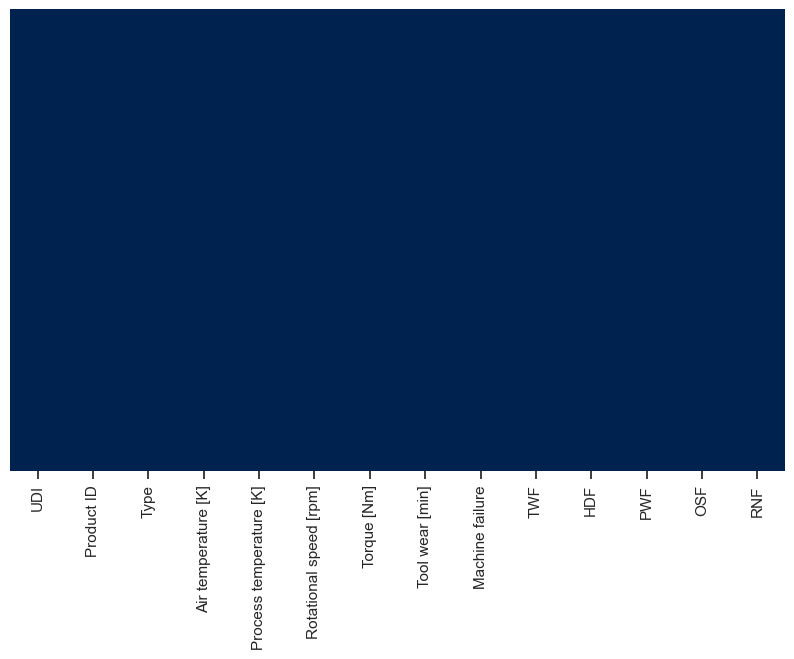

In [7]:
check_missing_values(df)

In [8]:
df.duplicated().sum()

0

# Summary Statistics

In [10]:
df.describe(include='all')

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.000,10000,10000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000
unique,NaN,10000,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,M14860,L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5000.500,NaN,NaN,300.005,310.006,1538.776,39.987,107.951,0.034,0.005,0.011,0.009,0.010,0.002
std,2886.896,NaN,NaN,2.000,1.484,179.284,9.969,63.654,0.181,0.068,0.107,0.097,0.099,0.044
min,1.000,NaN,NaN,295.300,305.700,1168.000,3.800,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,2500.750,NaN,NaN,298.300,308.800,1423.000,33.200,53.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,5000.500,NaN,NaN,300.100,310.100,1503.000,40.100,108.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,7500.250,NaN,NaN,301.500,311.100,1612.000,46.800,162.000,0.000,0.000,0.000,0.000,0.000,0.000


# Exploratory Data Analysis (EDA) and Visualization

In [90]:
# Create lists for categorical and numeric columns
cat_cols = []
num_cols = []

for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        num_cols.append(column)
    elif pd.api.types.is_object_dtype(df[column]):
        cat_cols.append(column)

print(f'Categorical columns: {len(cat_cols)}', cat_cols)
print(f'Numeric columns: {len(num_cols)}', num_cols)

Categorical columns: 2 ['Product ID', 'Type']
Numeric columns: 12 ['UDI', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']


🔎 **Observations:**

In [138]:
df.drop(['Product ID', 'UDI'], axis=1, inplace=True)

In [139]:
df[['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']] = df[['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']].astype(object)

In [140]:
# Create lists for categorical and numeric columns
cat_cols = []
num_cols = []

for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        num_cols.append(column)
    elif pd.api.types.is_object_dtype(df[column]):
        cat_cols.append(column)

print(f'Categorical columns: {len(cat_cols)}', cat_cols)
print(f'Numeric columns: {len(num_cols)}', num_cols)

Categorical columns: 7 ['Type', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
Numeric columns: 5 ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']


## Univariate Analysis

/var/folders/xm/3h6hfxmn0158s2wvp_w5r6700000gn/T/ipykernel_38975/3371970415.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


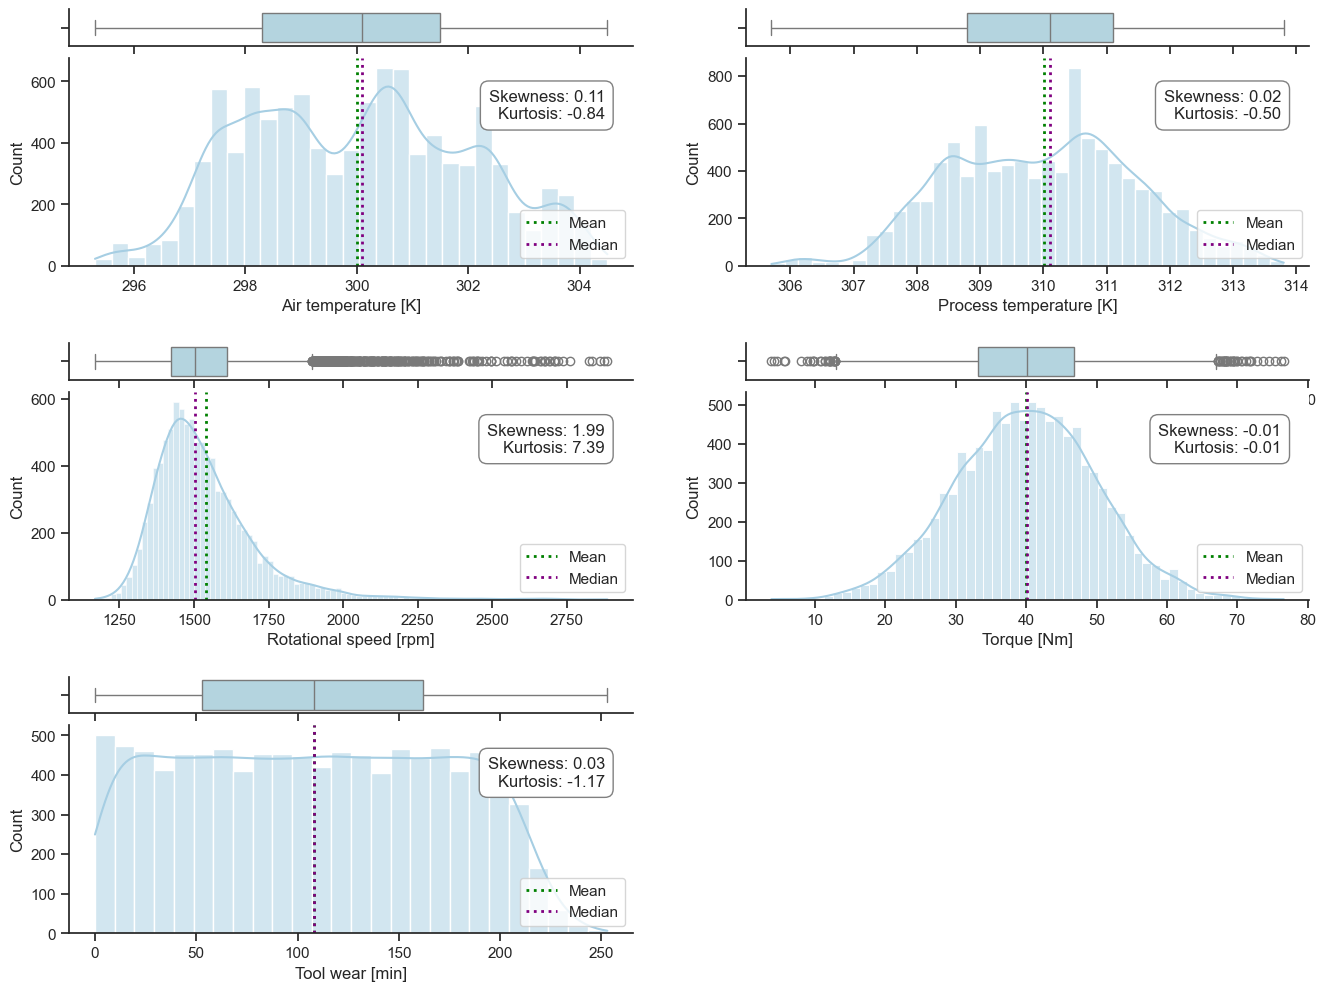

In [26]:
# number of columns of the subplots
n_cols = 2 
# set the number of rows with the predefined number of columns
n_rows = int(np.ceil(len(num_cols)/n_cols)) 

# Create figure
fig = plt.figure(figsize=(16, 4*n_rows))
outer = gridspec.GridSpec(n_rows, n_cols, wspace=0.2, hspace=0.3)

for i in range(len(num_cols)):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[i], 
                                             wspace=0.1, hspace=0.1, height_ratios=(0.15, 0.85))

    ax_box = plt.Subplot(fig, inner[0])
    sb.boxplot(data=df, x=num_cols[i], color='lightblue', ax=ax_box)
    ax_box.set_xlabel('')
    fig.add_subplot(ax_box)
        
    mean_value = df[num_cols[i]].mean()
    median_value = df[num_cols[i]].median()
    ax_hist = plt.Subplot(fig, inner[1])
    sb.histplot(data=df, x=num_cols[i], kde=True, ax=ax_hist)
    ax_hist.axvline(mean_value, color='green', linestyle='dotted', linewidth=2, label='Mean')
    ax_hist.axvline(median_value, color='purple', linestyle='dotted', linewidth=2, label='Median')
    # Add a legend
    ax_hist.legend(loc='lower right')
        
    # Calculate skewness and kurtosis
    skewness = df[num_cols[i]].skew()
    kurt = df[num_cols[i]].kurt()
    # Add skewness and kurtosis as text on the histogram plot
    ax_hist.text(0.95, 0.85, f"Skewness: {skewness:.2f}\nKurtosis: {kurt:.2f}", 
                     transform=ax_hist.transAxes, verticalalignment='top', horizontalalignment='right',
                     bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5'))
    fig.add_subplot(ax_hist)

plt.tight_layout()
plt.show()

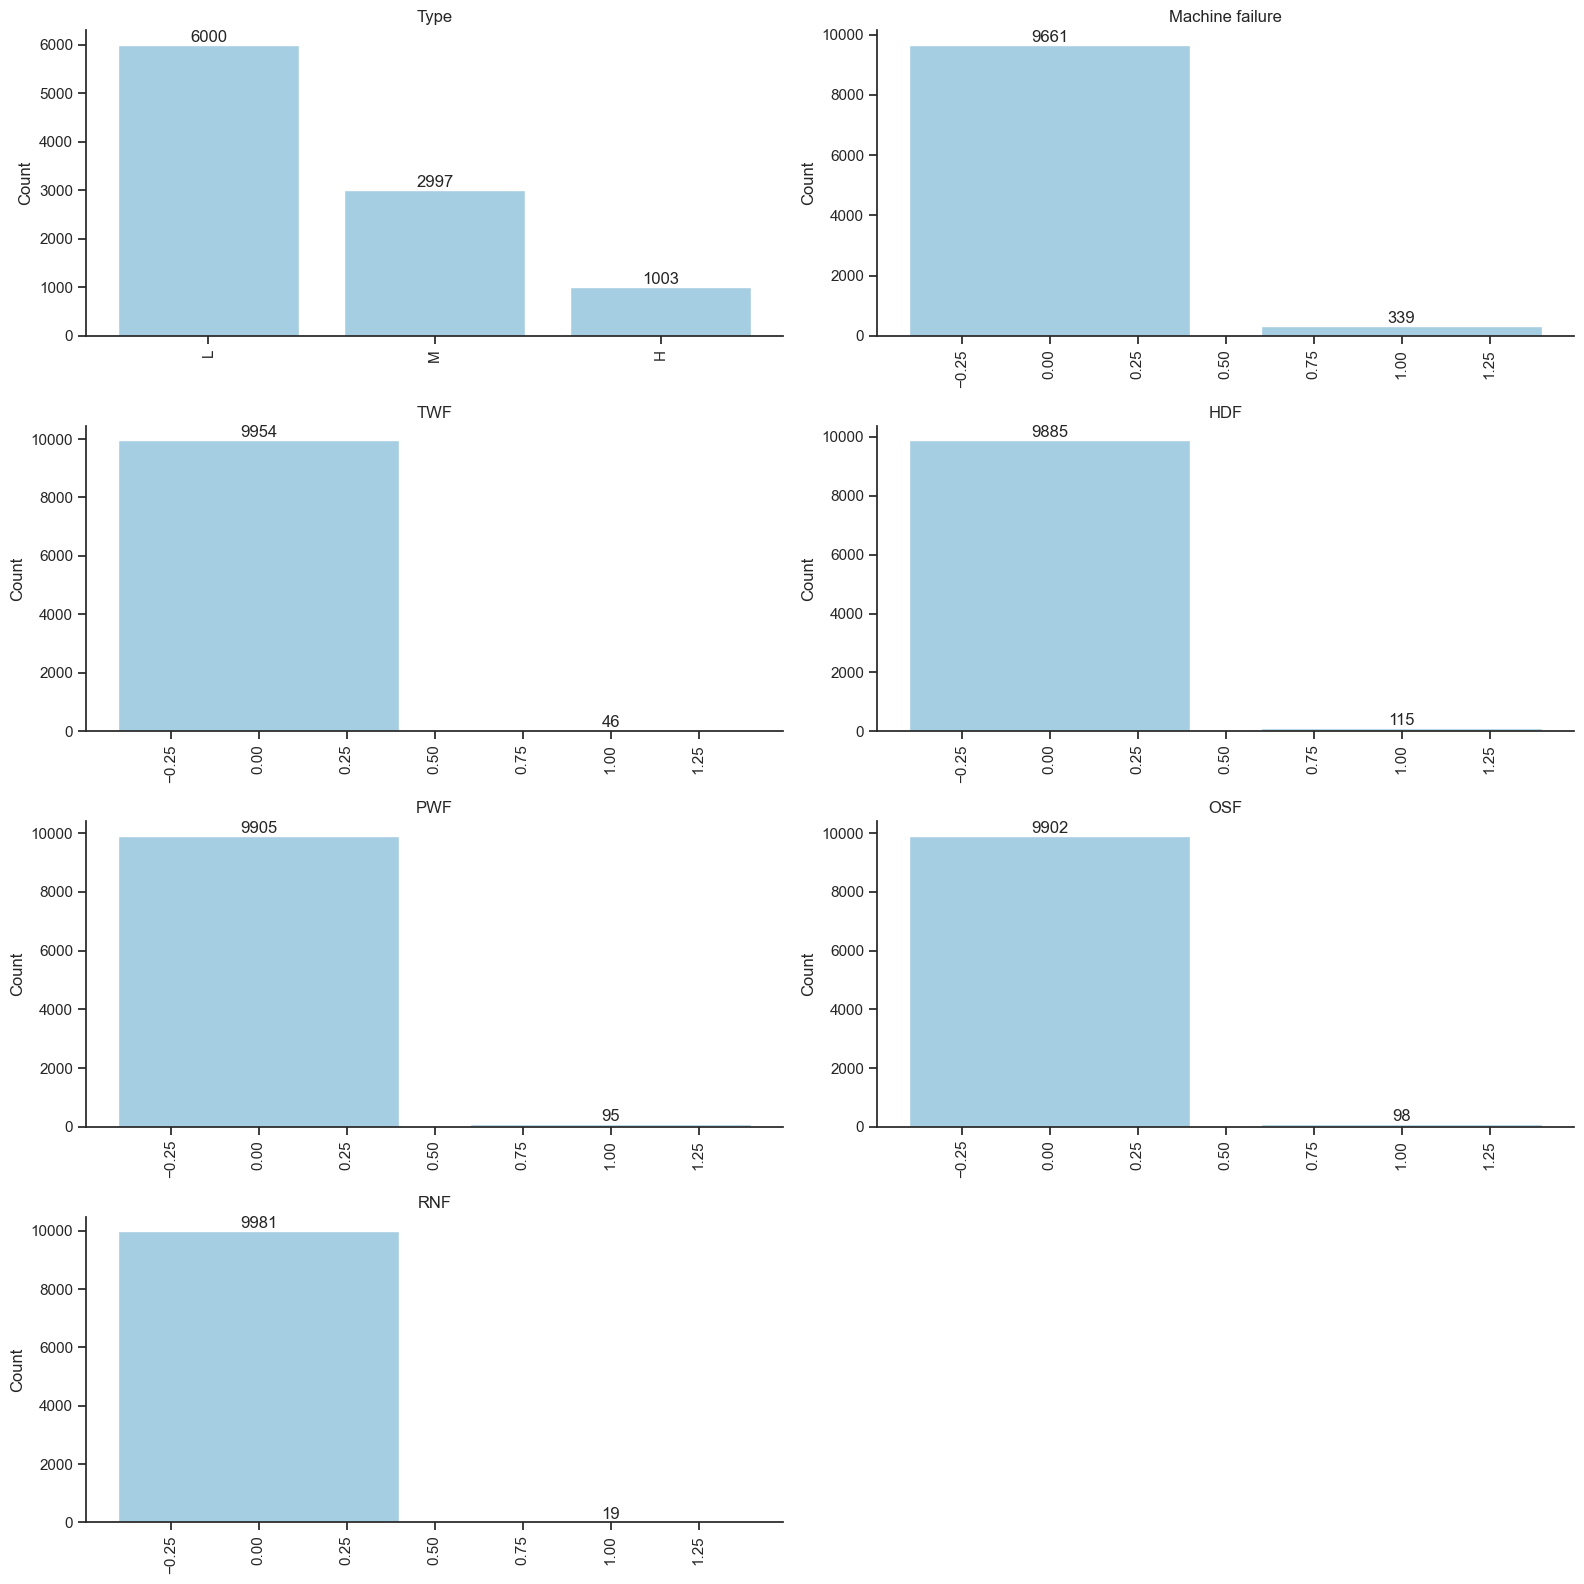

In [27]:
# number of columns of the subplots
n_cols = 2 
# set the number of rows with the predefined number of columns
n_rows = int(np.ceil(len(cat_cols)/n_cols)) 
    
# Create figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
# Flatten the axes array for easier indexing
axes = axes.flatten()
    
for i, feature in enumerate(cat_cols):
    bar_container = axes[i].bar(df[feature].value_counts().index, df[feature].value_counts().values)
    axes[i].set(ylabel='Count', title=feature)
    axes[i].bar_label(bar_container)
    axes[i].tick_params(axis='x', rotation=90)
        
# If the number of features is odd, remove the empty subplot
if len(cat_cols) % 2 != 0:
    fig.delaxes(axes[-1])
    
plt.tight_layout()
plt.show(block=False)

In [141]:
cond_1 = (df['TWF'] == 1) | (df['HDF'] == 1) | (df['PWF'] ==1) | (df['OSF'] == 1) | (df['RNF'] == 1)
cond_2 = df['Machine failure'] == 0

df[cond_1 & cond_2]

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
1221,M,297.000,308.300,1399,46.400,132,0,0,0,0,0,1
1302,L,298.600,309.800,1505,45.700,144,0,0,0,0,0,1
1748,H,298.400,307.700,1626,31.100,166,0,0,0,0,0,1
2072,L,299.600,309.500,1570,35.500,189,0,0,0,0,0,1
2559,L,299.300,309.000,1447,50.400,140,0,0,0,0,0,1
3065,M,300.100,309.200,1687,27.700,95,0,0,0,0,0,1
3452,H,301.600,310.500,1602,32.300,2,0,0,0,0,0,1
5471,L,302.700,312.300,1346,61.200,170,0,0,0,0,0,1
5489,L,302.600,312.100,1499,35.000,215,0,0,0,0,0,1
5495,H,302.900,312.500,1357,55.000,12,0,0,0,0,0,1


In [142]:
df.drop(df[cond_1 & cond_2].index, inplace=True)

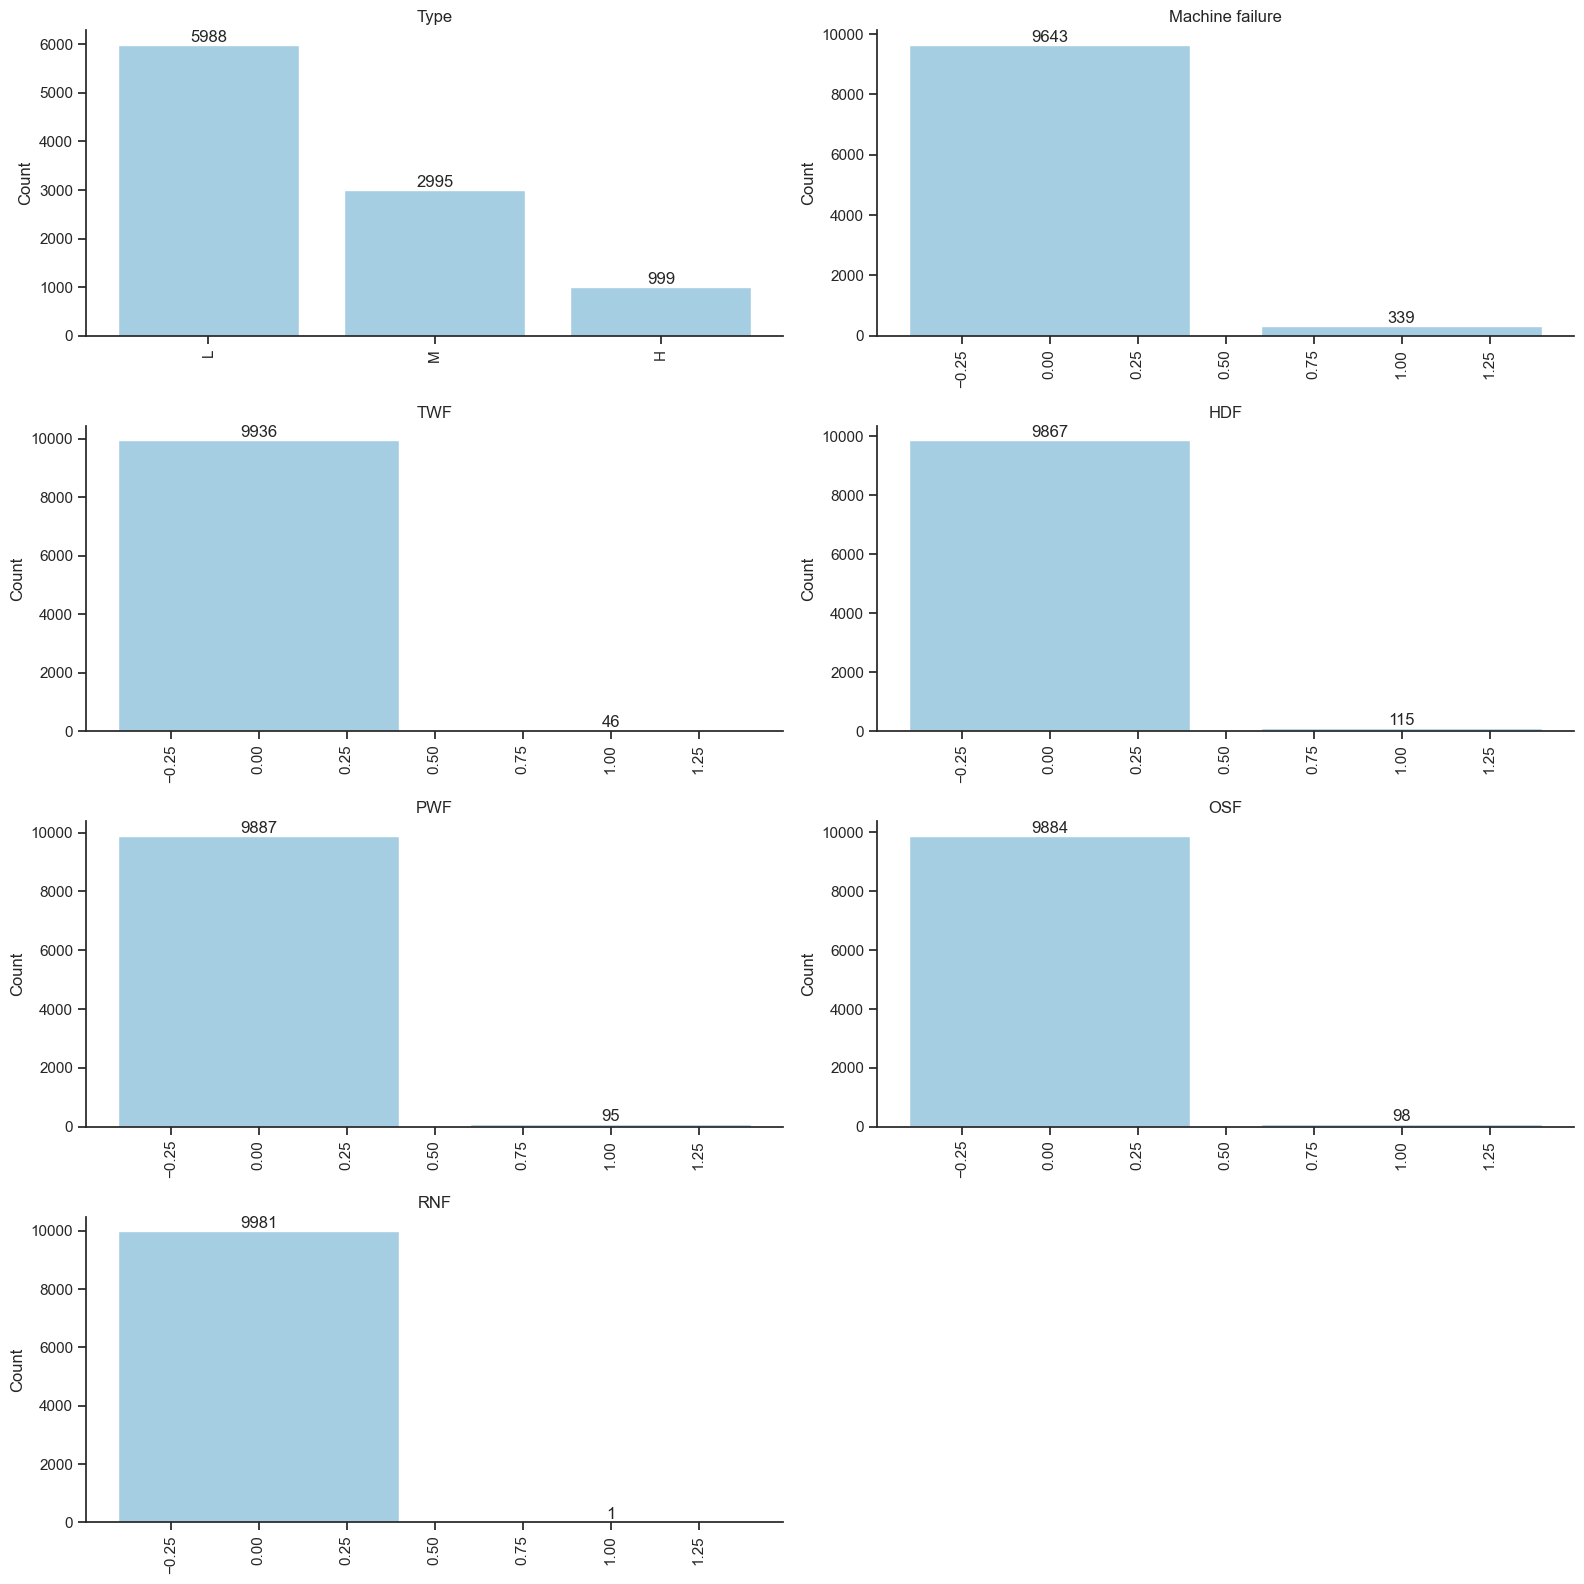

In [46]:
# number of columns of the subplots
n_cols = 2 
# set the number of rows with the predefined number of columns
n_rows = int(np.ceil(len(cat_cols)/n_cols)) 
    
# Create figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
# Flatten the axes array for easier indexing
axes = axes.flatten()
    
for i, feature in enumerate(cat_cols):
    bar_container = axes[i].bar(df[feature].value_counts().index, df[feature].value_counts().values)
    axes[i].set(ylabel='Count', title=feature)
    axes[i].bar_label(bar_container)
    axes[i].tick_params(axis='x', rotation=90)
        
# If the number of features is odd, remove the empty subplot
if len(cat_cols) % 2 != 0:
    fig.delaxes(axes[-1])
    
plt.tight_layout()
plt.show(block=False)

In [143]:
# Removing "Random Failures" of the "Failure_type" column.
df = df.loc[df['RNF'] != 1]

In [144]:
df.drop('RNF', axis=1, inplace=True)

In [145]:
df.reset_index(drop=True, inplace=True)

In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9981 entries, 0 to 9980
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     9981 non-null   object 
 1   Air temperature [K]      9981 non-null   float64
 2   Process temperature [K]  9981 non-null   float64
 3   Rotational speed [rpm]   9981 non-null   int64  
 4   Torque [Nm]              9981 non-null   float64
 5   Tool wear [min]          9981 non-null   int64  
 6   Machine failure          9981 non-null   object 
 7   TWF                      9981 non-null   object 
 8   HDF                      9981 non-null   object 
 9   PWF                      9981 non-null   object 
 10  OSF                      9981 non-null   object 
dtypes: float64(3), int64(2), object(6)
memory usage: 857.9+ KB


/var/folders/xm/3h6hfxmn0158s2wvp_w5r6700000gn/T/ipykernel_38975/964960462.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


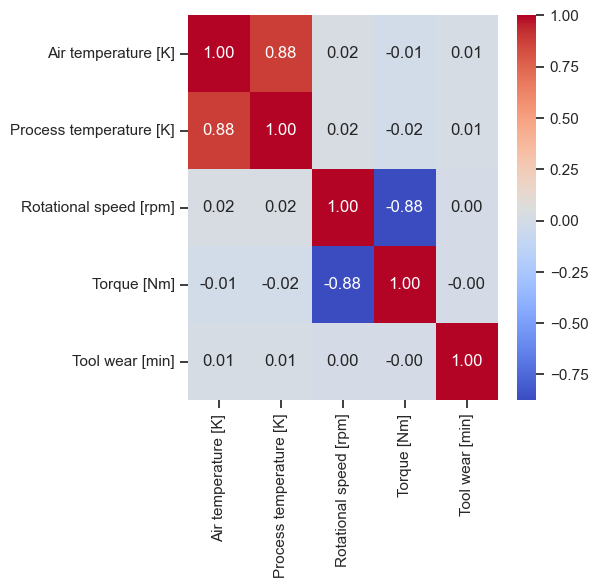

In [63]:
# Plot correlation of numeric values applying mask
corr = df.corr()
plt.figure(figsize=(5,5))
sb.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

# Data Preparation

In [147]:
print(df[['TWF', 'HDF', 'PWF','OSF']].sum().sum())
print(len(df[df['Machine failure'] == 1]))

353
338


🔎 **Observations:** There are some rows that has more than 1 failure type

In [148]:
df['Sum'] = df['TWF'] + df['HDF'] + df['PWF'] + df['OSF']
df[df['Sum'] > 1]

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,Sum
69,L,298.900,309.000,1410,65.700,191,1,0,0,1,1,2
1322,M,298.800,310.100,1243,74.500,194,1,0,0,1,1,2
1494,L,298.000,308.700,1268,69.400,189,1,0,0,1,1,2
3846,L,302.400,311.000,1338,67.600,194,1,0,0,1,1,2
3935,L,302.300,311.400,1333,66.700,205,1,0,0,1,1,2
4246,L,302.600,311.000,1284,68.000,114,1,0,1,1,0,2
4334,M,301.700,309.800,1284,68.200,111,1,0,1,1,0,2
4362,L,302.000,309.900,1308,57.600,197,1,0,1,0,1,2
4375,L,301.700,309.500,1298,65.500,229,1,0,1,0,1,2
4409,L,302.600,310.400,1365,66.800,80,1,0,1,1,0,2


In [149]:
len(df[df['Sum'] > 1])

23

🔎 **Observations:** We have enough datapoints to remove these rows.

In [150]:
# Removing rows where it has more than 1 failure type
df = df.loc[df['Sum'] <= 1]
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9958 entries, 0 to 9957
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     9958 non-null   object 
 1   Air temperature [K]      9958 non-null   float64
 2   Process temperature [K]  9958 non-null   float64
 3   Rotational speed [rpm]   9958 non-null   int64  
 4   Torque [Nm]              9958 non-null   float64
 5   Tool wear [min]          9958 non-null   int64  
 6   Machine failure          9958 non-null   object 
 7   TWF                      9958 non-null   object 
 8   HDF                      9958 non-null   object 
 9   PWF                      9958 non-null   object 
 10  OSF                      9958 non-null   object 
 11  Sum                      9958 non-null   object 
dtypes: float64(3), int64(2), object(7)
memory usage: 933.7+ KB


In [151]:
conditions = [df['TWF'] == 1, df['HDF'] == 1, df['PWF'] == 1, df['OSF'] == 1]
choices = ['TWF', 'HDF', 'PWF', 'OSF']
default_value = 'No Failure'

df['FailureType'] = np.select(conditions, choices, default=default_value)

In [152]:
df[df['Machine failure'] == 1].sample(10)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,Sum,FailureType
8154,L,299.600,310.900,1229,65.200,209,1,0,0,0,1,1,OSF
2741,M,299.700,309.200,1685,28.900,179,1,0,0,0,0,0,No Failure
4240,M,302.600,311.000,1329,48.600,111,1,0,1,0,0,1,HDF
247,L,298.000,308.300,1362,56.800,216,1,0,0,0,1,1,OSF
4733,L,303.400,311.700,1295,51.300,51,1,0,1,0,0,1,HDF
9535,L,299.600,310.700,1922,23.300,205,1,1,0,0,0,1,TWF
7473,L,300.500,311.800,1524,38.900,214,1,1,0,0,0,1,TWF
4625,L,303.300,311.400,1497,46.000,234,1,1,0,0,0,1,TWF
2590,L,299.100,308.800,1320,67.500,20,1,0,0,1,0,1,PWF
4388,L,302.400,310.200,1331,45.500,53,1,0,1,0,0,1,HDF


In [153]:
df.drop(['TWF', 'HDF', 'PWF','OSF', 'Sum'], axis=1, inplace=True)

In [154]:
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,FailureType
0,M,298.100,308.600,1551,42.800,0,0,No Failure
1,L,298.200,308.700,1408,46.300,3,0,No Failure
2,L,298.100,308.500,1498,49.400,5,0,No Failure
3,L,298.200,308.600,1433,39.500,7,0,No Failure
4,L,298.200,308.700,1408,40.000,9,0,No Failure


In [155]:
df[(df['FailureType'] == 'No Failure') & (df['Machine failure'] == 1)]

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,FailureType
1433,H,298.800,309.900,1439,45.200,40,1,No Failure
2741,M,299.700,309.200,1685,28.900,179,1,No Failure
4031,M,301.900,310.900,1419,47.700,20,1,No Failure
4663,M,303.600,311.800,1421,44.800,101,1,No Failure
5508,M,302.300,311.800,1363,54.000,119,1,No Failure
5910,L,300.600,310.700,1438,48.500,78,1,No Failure
6445,L,300.500,309.800,1663,29.100,145,1,No Failure
8468,L,298.400,309.600,1710,27.300,163,1,No Failure
8975,L,297.200,308.100,1431,49.700,210,1,No Failure


In [157]:
# Removing rows where it has 'No Failure' type and Machine failure is positive
df = df[~(df['FailureType'] == 'No Failure') | (df['Machine failure'] != 1)]
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9949 entries, 0 to 9948
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     9949 non-null   object 
 1   Air temperature [K]      9949 non-null   float64
 2   Process temperature [K]  9949 non-null   float64
 3   Rotational speed [rpm]   9949 non-null   int64  
 4   Torque [Nm]              9949 non-null   float64
 5   Tool wear [min]          9949 non-null   int64  
 6   Machine failure          9949 non-null   object 
 7   FailureType              9949 non-null   object 
dtypes: float64(3), int64(2), object(3)
memory usage: 621.9+ KB


In [159]:
df.drop('Machine failure', axis=1, inplace=True)

In [185]:
df.to_csv('../Data/Processed/final.csv')

In [160]:
# Create lists for categorical and numeric columns
cat_cols = []
num_cols = []

for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        num_cols.append(column)
    elif pd.api.types.is_object_dtype(df[column]):
        cat_cols.append(column)

print(f'Categorical columns: {len(cat_cols)}', cat_cols)
print(f'Numeric columns: {len(num_cols)}', num_cols)

Categorical columns: 2 ['Type', 'FailureType']
Numeric columns: 5 ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']


In [161]:
cat_features = cat_cols.copy()
cat_features.remove('FailureType')

num_features = num_cols.copy()

In [162]:
# Create preprocessor ColumnTransformer to do OneHotEncoder for CATEGORIC_FEATURES and StandardScaler() for NUMERIC_FEATURES
# Define the pipelines for numeric and categorical transformations
num_pipeline = Pipeline([
    ('num_features', StandardScaler())
])
cat_pipeline = Pipeline([
    ('cat_features', OneHotEncoder())
])
# Create the ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num_trans', num_pipeline, num_features),
    ('cat_trans', cat_pipeline, cat_features)
])
# Fit and transform the data
df_transformed = preprocessor.fit_transform(df)
# Converting the transformed data back to a dataframe for easier visualization
# The transformed data will have new column names, especially for the one hot encoded categories
encoded_feature_names = preprocessor.named_transformers_['cat_trans'].get_feature_names_out(cat_features)
new_column_names = list(num_features) + list(encoded_feature_names)
df_transformed = pd.DataFrame(df_transformed, columns=new_column_names)
df_transformed.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Type_H,Type_L,Type_M
0,-0.951,-0.946,0.065,0.291,-1.695,0.000,0.000,1.000
1,-0.901,-0.878,-0.733,0.644,-1.648,0.000,1.000,0.000
2,-0.951,-1.013,-0.231,0.957,-1.616,0.000,1.000,0.000
3,-0.901,-0.946,-0.593,-0.043,-1.585,0.000,1.000,0.000
4,-0.901,-0.878,-0.733,0.008,-1.553,0.000,1.000,0.000


## PCA Analysis

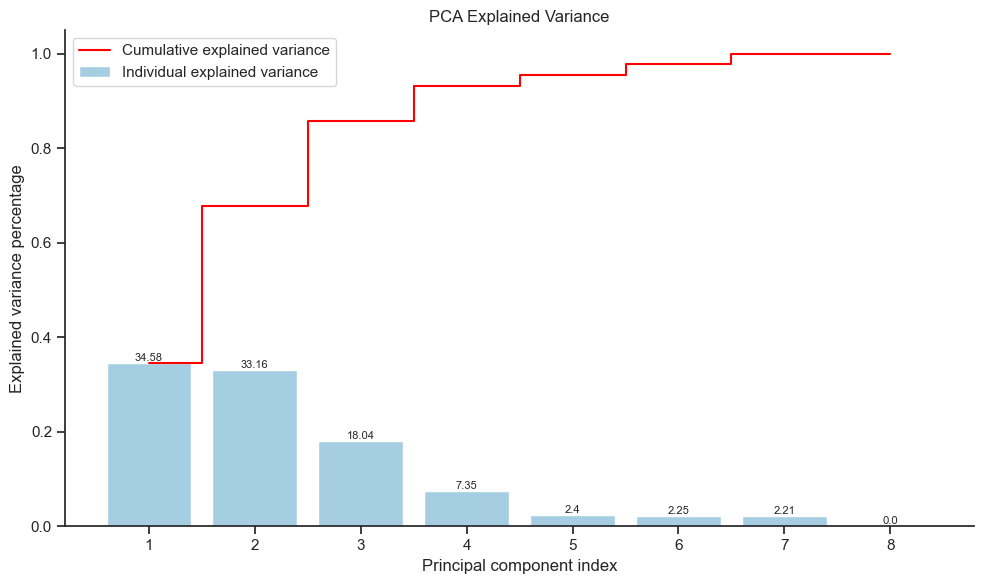

In [165]:
# Define PCA function
pca = PCA()
pca.fit(df_transformed)  # Assumindo que df_transformed é o seu DataFrame transformado

# PCA variance explained
exp_var = pca.explained_variance_ratio_
cum_exp_var = exp_var.cumsum()

# Number of components
n_pca_components = len(exp_var)

# Create the graphic
plt.figure(figsize=(10, 6))
bars = plt.bar(range(1, n_pca_components + 1), exp_var, align='center',
               label='Individual explained variance')
plt.step(range(1, n_pca_components + 1), cum_exp_var, where='mid',
         label='Cumulative explained variance', color='red')

# Add labels in each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval*100, 2), 
             va='bottom', ha='center', fontsize=8)

# Adjust others elements of the graphic
plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')
plt.xticks(ticks=list(range(1, n_pca_components + 1)))
plt.title('PCA Explained Variance')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

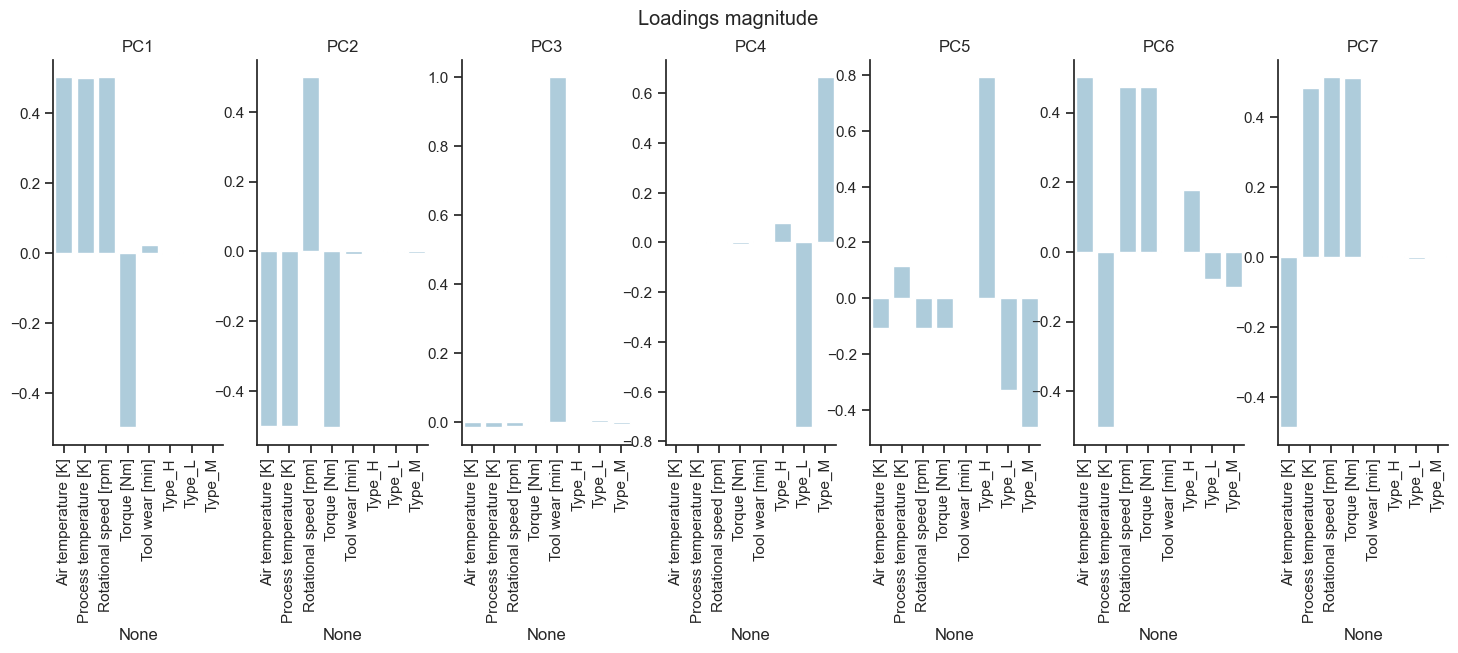

In [167]:
# PCA with 7 components to analyse what explain each component
pca7 = PCA(n_components=7)
X_pca7 = pd.DataFrame(data=pca7.fit_transform(df_transformed), columns=['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'PC7'])

# Configure of the graphics
fig, axs = plt.subplots(ncols=7, figsize=(18,5))
fig.suptitle('Loadings magnitude')

all_features = num_features + list(encoded_feature_names)  # Use encoded_feature_names do 
pca_loadings = pd.DataFrame(data=pca7.components_, columns=all_features)

#Plot the bar graphics
for j in range(7):
    ax = axs[j]
    sb.barplot(ax=ax, x=pca_loadings.columns, y=pca_loadings.values[j])
    ax.tick_params(axis='x', rotation=90)
    ax.title.set_text('PC'+str(j+1))
plt.show()

# Modelling

In [171]:
def get_metrics(y_true, y_pred):
    # Calculating F1 scores for each class
    f1_scores_per_class = f1_score(y_true, y_pred, average=None)
    
    dict_metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_true, y_pred),
        'Macro Recall': recall_score(y_true, y_pred, average='macro'),
        'Macro Precision': precision_score(y_true, y_pred, average='macro'),
        'Macro F1': f1_score(y_true, y_pred, average='macro'),
        'F1 Scores per Class': f1_scores_per_class
    }
    return dict_metrics

In [173]:
df_model = df.copy()
x = df_model[num_features + cat_features]
y = df_model['FailureType']
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=101, test_size=0.2, stratify=y)

## Modeling with PCA

In [175]:
# Creating pipeline with PCA analysis and balanced class
pip_model_pca = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=4)),
    ('model', RandomForestClassifier(random_state=101))
])

# Fit pipeline with PCA
weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
pip_model_pca.fit(x_train, y_train, model__sample_weight=weights)

# Generate Predictions using the correctly fitted pipeline
y_pred = pip_model_pca.predict(x_test)

# Evaluate Metrics
metrics = get_metrics(y_test, y_pred)

# View Results
metrics

/opt/anaconda3/envs/xgboost_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'Accuracy': 0.9733668341708542,
 'Balanced Accuracy': 0.37437791601866255,
 'Macro Recall': 0.37437791601866255,
 'Macro Precision': 0.4952284263959391,
 'Macro F1': 0.41820443111645983,
 'F1 Scores per Class': array([0.        , 0.98640677, 0.72      , 0.38461538, 0.        ])}

## Modelling without PCA

In [176]:
# Creating pipeline without PCA analysis and balanced class with parameter by model
pip_model_no_pca = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=101))
])

# Fit pipeline with sample weights
weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
pip_model_no_pca.fit(x_train, y_train, model__sample_weight=weights)

# Step 1: Generate Predictions
y_pred = pip_model_no_pca.predict(x_test)

# Step 2: Evaluate Metrics
metrics = get_metrics(y_test, y_pred)

# Step 3: View Results
metrics

/opt/anaconda3/envs/xgboost_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'Accuracy': 0.9844221105527639,
 'Balanced Accuracy': 0.5581259720062208,
 'Macro Recall': 0.5581259720062208,
 'Macro Precision': 0.7570347648261759,
 'Macro F1': 0.6353271953271953,
 'F1 Scores per Class': array([0.8       , 0.99202059, 0.76923077, 0.61538462, 0.        ])}

In [177]:
# Creating pipeline without PCA analysis and balanced class with parameter by model
pip_model_no_pca = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingClassifier(random_state=101))
])

# Fit pipeline with sample weights
weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
pip_model_no_pca.fit(x_train, y_train, model__sample_weight=weights)

# Step 1: Generate Predictions
y_pred = pip_model_no_pca.predict(x_test)

# Step 2: Evaluate Metrics
metrics = get_metrics(y_test, y_pred)

# Step 3: View Results
metrics

{'Accuracy': 0.9582914572864322,
 'Balanced Accuracy': 0.8920165889061689,
 'Macro Recall': 0.8920165889061689,
 'Macro Precision': 0.6143595888872174,
 'Macro F1': 0.6899265198823115,
 'F1 Scores per Class': array([0.82352941, 0.97808292, 0.7804878 , 0.68571429, 0.18181818])}

## Tuning the Model

In [182]:
# New parameters for fine-tuning the RandomForestClassifier
fine_tune_params = {
    'model__n_estimators': [50, 100, 200, 300, 400, 500],
    'model__max_depth': [None, 5, 10, 15, 20]
}

# Running a new GridSearchCV for fine-tuning
fine_tune_grid = GridSearchCV(pip_model_no_pca, fine_tune_params, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
fine_tune_grid.fit(x_train, y_train)

# Collecting and printing the fine-tuned results
fine_tuned_results = pd.DataFrame(fine_tune_grid.cv_results_)
fine_tuned_best_index = fine_tuned_results['mean_test_score'].idxmax()
fine_tuned_best_params = fine_tuned_results.loc[fine_tuned_best_index, 'params']

# Print best model parameters
print("Best fine-tuned model parameters:")
print(fine_tuned_best_params)

# Finding the best estimator paramaters
tuned_model = fine_tune_grid.best_estimator_
y_pred = tuned_model.predict(x_test)

# View new perfomance (focus on F1-score)
get_metrics(y_test, y_pred)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


Best fine-tuned model parameters:
{'model__max_depth': 5, 'model__n_estimators': 300}


{'Accuracy': 0.9889447236180905,
 'Balanced Accuracy': 0.7117742353551063,
 'Macro Recall': 0.7117742353551063,
 'Macro Precision': 0.7341222088873096,
 'Macro F1': 0.721952645429852,
 'F1 Scores per Class': array([0.97674419, 0.99430936, 0.8       , 0.83870968, 0.        ])}

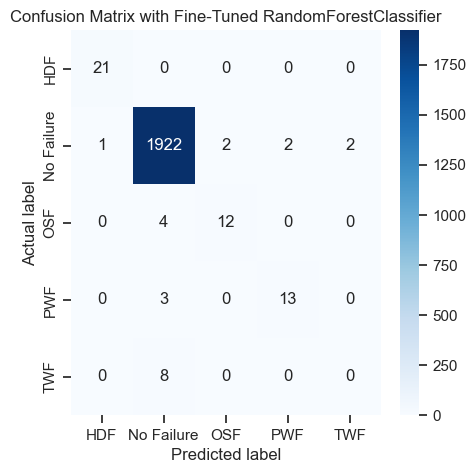

In [183]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(5, 5))  # Larger figure size
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues',  # Use 'd' to format numbers as integers
            xticklabels=np.unique(y_test), 
            yticklabels=np.unique(y_pred))
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix with Fine-Tuned RandomForestClassifier')
plt.show()


# Saving Model

In [184]:
with open('../Models/model.pkl', 'wb') as model_file:
    pickle.dump(tuned_model, model_file)